<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 2
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r2, r3, r4, r5</span>. (fill in your student numbers!)

In this group assignment your team will delve into some deep learning applications for computer vision. The assignment will be delivered in the same groups from *Group assignment 1* and you start from this template notebook. The notebook you submit for grading is the last notebook you submit in the [Kaggle competition](https://www.kaggle.com/t/d11be6a431b84198bc85f54ae7e2563f) prior to the deadline on **Tuesday 24 May 23:59**. Closely follow [these instructions](https://github.com/gourie/kaggle_inclass) for joining the competition, sharing your notebook with the TAs and making a valid notebook submission to the competition. A notebook submission not only produces a *submission.csv* file that is used to calculate your competition score, it also runs the entire notebook and saves its output as if it were a report. This way it becomes an all-in-one-place document for the TAs to review. As such, please make sure that your final submission notebook is self-contained and fully documented (e.g. provide strong arguments for the design choices that you make). Most likely, this notebook format is not appropriate to run all your experiments at submission time (e.g. the training of CNNs is a memory hungry and time consuming process; due to limited Kaggle resources). It can be a good idea to distribute your code otherwise and only summarize your findings, together with your final predictions, in the submission notebook. For example, you can substitute experiments with some text and figures that you have produced "offline" (e.g. learning curves and results on your internal validation set or even the test set for different architectures, pre-processing pipelines, etc). We advise you to first go through the PDF of this assignment entirely before you really start. Then, it can be a good idea to go through this notebook and use it as your first notebook submission to the competition. You can make use of the *Group assignment 2* forum/discussion board on Toledo if you have any questions. Good luck and have fun!

---------------------------------------------------------------
NOTES:
* This notebook is just a template. Please keep the five main sections, but feel free to adjust further in any way you please!
* Clearly indicate the improvements that you make! You can for instance use subsections like: *3.1. Improvement: applying loss function f instead of g*.


# 1. Overview
This assignment consists of *three main parts* for which we expect you to provide code and extensive documentation in the notebook:
* Image classification (Sect. 2)
* Semantic segmentation (Sect. 3)
* Adversarial attacks (Sect. 4)

In the first part, you will train an end-to-end neural network for image classification. In the second part, you will do the same for semantic segmentation. For these two tasks we expect you to put a significant effort into optimizing performance and as such competing with fellow students via the Kaggle competition. In the third part, you will try to find and exploit the weaknesses of your classification and/or segmentation network. For the latter there is no competition format, but we do expect you to put significant effort in achieving good performance on the self-posed goal for that part. Finally, we ask you to reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Sect. 5). It is important to note that only a small part of the grade will reflect the actual performance of your networks. However, we do expect all things to work! In general, we will evaluate the correctness of your approach and your understanding of what you have done that you demonstrate in the descriptions and discussions in the final notebook.

## 1.1 Deep learning resources
If you did not yet explore this in *Group assignment 1 (Sect. 2)*, we recommend using the TensorFlow and/or Keras library for building deep learning models. You can find a nice crash course [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,Activation,Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import cv2

print("Load modules complete!")

ModuleNotFoundError: No module named 'segmentation_models'

## 1.2 PASCAL VOC 2009
For this project you will be using the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. This dataset consists of colour images of various scenes with different object classes (e.g. animal: *bird, cat, ...*; vehicle: *aeroplane, bicycle, ...*), totalling 20 classes.

In [9]:
# Loading the training data
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

# Show some examples
# fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
# for i, label in enumerate(labels):
#     df = train_df.loc[train_df[label] == 1]
#     axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
#     axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
#     axs[0, i].axis("off")
#     axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
#     axs[1, i].axis("off")
    
# plt.show()

# # The training dataframe contains for each image 20 columns with the ground truth classification labels and 20 column with the ground truth segmentation maps for each class
# train_df.head(1)

The training set contains 749 examples.


In [11]:
# Loading the test data
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

# The test dataframe is similar to the training dataframe, but here the values are -1 --> your task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)

The test set contains 750 examples.


,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,img,seg
Id,,,,,,,,,,,,,,,,,,,,,
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,"[[[139, 130, 115], [136, 127, 112], [112, 102,...","[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."


## 1.3 Your Kaggle submission
Your filled test dataframe (during Sect. 2 and Sect. 3) must be converted to a submission.csv with two rows per example (one for classification and one for segmentation) and with only a single prediction column (the multi-class/label predictions running length encoded). You don't need to edit this section. Just make sure to call this function at the right position in this notebook.

In [ ]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). Use the training set to train your CNN and compete on the test set (by filling in the segmentation column in the test dataframe).

In [ ]:
class RandomSegmentationModel:
    """
    Random segmentation model: 
        - generates random label maps for the inputs based on the class distributions observed during training
        - every pixel in an input can only have one label
    """
    def fit(self, X, Y):
        """
        Adjusts the class ratio variable to the one observed in Y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        Y: list of arrays - n x (height x width)

        Returns
        -------
        self
        """
        self.distribution = np.mean([[np.sum(Y_ == i) / Y_.size for i in range(len(labels) + 1)] for Y_ in Y], axis=0)
        print("Setting class distribution to:\nbackground: {}\n{}".format(self.distribution[0], "\n".join(f"{label}: {p}" for label, p in zip(labels, self.distribution[1:]))))
        return self
        
    def predict(self, X):
        """
        Predicts for each input a label map.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        Y_pred: list of arrays - n x (height x width)
        """
        np.random.seed(0)
        return [np.random.choice(np.arange(len(labels) + 1), size=X_.shape[:2], p=self.distribution) for X_ in X]
    
    def __call__(self, X):
        return self.predict(X)
    
model = RandomSegmentationModel()
model.fit(train_df["img"], train_df["seg"])
test_df.loc[:, "seg"] = model.predict(test_df["img"])
test_df.head(1)

## 3.2 Transfer Learning on Semantic Segmentation 
As seen in the performance of the trained model from scrath efficiency can be improved. For this matter, we will train a model using transfer learning.
In Semantic Segmentation several architectures are found, amount popular optiosn are  VGG-UNet, FastFCN, DeepLab among others. We will be using the first approach namely VGG16, for more details visit: https://keras.io/api/applications/#inception3

### 3.2.1 Analysig the data

In [10]:
# Show some examples of img and its corresponding smg
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

def plot_img_seg(original_img, real_label, predicted_label=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    col = 2
    if predicted_label is not None:
        col = 3
    # First Img
    plt.subplot(int(f"1{col}1"))
    plt.imshow(original_img)
    plt.title("Original Image")
    
    # Second Img
    plt.subplot(int(f"1{col}2"))
    plt.imshow(real_label)
    plt.title("Truth Label")
    
    # Third Img
    if predicted_label is not None:
        plt.subplot(int(f"1{col}3"))
        plt.imshow(predicted_label)
        plt.title("Predicted Label")
        
def preproces_img(img):
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     img = cv2.resize(img,(224,224, 3)) #(224, 224, 1, 3)
#     img = np.expand_dims(img, axis=2)
    img = cv2.resize(img,(224,224))
#     print(img.shape)
    return img

def preproces_seg(seg):
    seg = cv2.resize(seg,(224,224),interpolation = cv2.INTER_NEAREST)
    seg = np.expand_dims(seg, axis=2)
#     print(seg.shape)
    return seg

train_df['img'] = train_df['img'].apply(preproces_img)
train_df['seg'] = train_df['seg'].apply(preproces_seg)

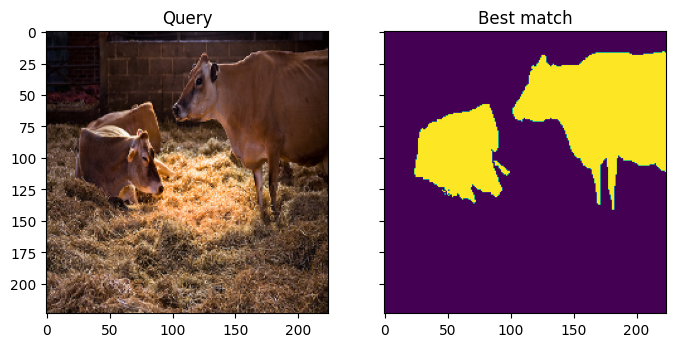

In [16]:
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(train_df['img'][0])
axes[0].set_title("Query")
axes[1].imshow(train_df['seg'][0])
axes[1].set_title("Best match")
plt.show()

In [11]:
from keras.utils import normalize, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

train_imgs = np.stack(train_df['img'].to_numpy())
train_seg = np.stack(train_df['seg'].to_numpy())
X_train, X_test, y_train, y_test = train_test_split(train_imgs, train_seg, test_size = 0.20,  random_state=12)
print("X_training Images Size:", X_train.shape)
print("y_training Labels Size:", y_train.shape)
print("X_test Images Size:", X_test.shape)
print("y_test Labels Size:", y_test.shape)

y_train = to_categorical(y_train, num_classes=21)
y_test = to_categorical(y_test, num_classes=21)

print("X_training Images Size:", X_train.shape)
print("y_training Labels Size:", y_train.shape)
print("X_test Images Size:", X_test.shape)
print("y_test Labels Size:", y_test.shape)



X_training Images Size: (599, 224, 224, 3)
y_training Labels Size: (599, 224, 224, 1)
X_test Images Size: (150, 224, 224, 3)
y_test Labels Size: (150, 224, 224, 1)
X_training Images Size: (599, 224, 224, 3)
y_training Labels Size: (599, 224, 224, 21)
X_test Images Size: (150, 224, 224, 3)
y_test Labels Size: (150, 224, 224, 21)


In [11]:
print(y_test[0].shape)

(224, 224, 21)


In [ ]:
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(X_train[0])
axes[0].set_title("Query")
# axes[1].imshow(y_train[0])
# axes[1].set_title("Best match")
plt.show()

In [18]:
test = train_seg.reshape(749*224*224)
print(test.shape)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_seg), y=test)
weights_norm = normalize([weights])
weight_dict = {}
for i in range(len(weights)):
    weight_dict[i] = weights[i]
print(weight_dict)


(37581824,)
{0: 0.0612385947532657, 1: 6.75906314363553, 2: 15.713225394818483, 3: 4.867397569760811, 4: 6.015093663171103, 5: 5.9390785677622615, 6: 3.2984627785488154, 7: 3.6665287150972286, 8: 2.8645091206711557, 9: 5.765442559081796, 10: 7.0189067994927505, 11: 3.4763897252601383, 12: 6.4374715976196555, 13: 5.707886144892775, 14: 4.410797879070196, 15: 1.1621301262819763, 16: 8.831652157892313, 17: 5.202432205894466, 18: 4.9775285690710485, 19: 3.9267634601361427, 20: 4.729752563387628}
[[0.00219648 0.24243091 0.5635946  0.17458153 0.21574656 0.21302009
  0.11830772 0.13150933 0.10274287 0.20679219 0.25175086 0.12468952
  0.23089621 0.20472779 0.15820443 0.04168274 0.31676956 0.1865984
  0.17853166 0.14084331 0.16964455]]


In [21]:
print(type(ArithmeticErrorweights_norm[0]))

<class 'numpy.ndarray'>


In [ ]:
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models
import segmentation_models as sm

In [27]:
# dice_loss = sm.losses.DiceLoss(class_weights = weights_norm[0]) 
dice_loss = sm.losses.DiceLoss(class_weights = 1/21*np.ones(21)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold = 0.5), sm.metrics.FScore(threshold = 0.5)]

In [29]:
model0 = build_unet()
model0.compile(optimizer='adam', loss=total_loss, metrics=metrics)

58889256/58889256 [==============================] - 0s 0us/step


In [30]:
history = model0.fit(X_train, 
                    y_train,
                   batch_size=8,
#                    verbose=1,
                   epochs=15,
                   validation_data=(X_test,y_test),
                   shuffle=False)

Epoch 1/15


2023-05-23 16:59:31.756847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


75/75 [==============================] - 68s 553ms/step - loss: 1.0215 - iou_score: 0.4475 - f1-score: 0.4498 - val_loss: 1.0405 - val_iou_score: 0.3777 - val_f1-score: 0.3859
Epoch 2/15
75/75 [==============================] - 26s 347ms/step - loss: 1.0113 - iou_score: 0.5480 - f1-score: 0.5563 - val_loss: 1.0091 - val_iou_score: 0.5182 - val_f1-score: 0.5242
Epoch 3/15
75/75 [==============================] - 26s 342ms/step - loss: 1.0081 - iou_score: 0.5507 - f1-score: 0.5582 - val_loss: 1.0075 - val_iou_score: 0.5684 - val_f1-score: 0.5744
Epoch 4/15
75/75 [==============================] - 26s 346ms/step - loss: 1.0069 - iou_score: 0.5447 - f1-score: 0.5522 - val_loss: 1.0070 - val_iou_score: 0.5276 - val_f1-score: 0.5338
Epoch 5/15
75/75 [==============================] - 27s 355ms/step - loss: 1.0063 - iou_score: 0.5227 - f1-score: 0.5305 - val_loss: 1.0063 - val_iou_score: 0.5191 - val_f1-score: 0.5272
Epoch 6/15
75/75 [==============================] - 26s 348ms/step - loss: 1

In [38]:
model0.save('VGG16_model3.h5')

In [46]:
preprocess_input1 = sm.get_preprocessing('resnet34')

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
n_classes = 21
activation = 'softmax'
lr = 0.0001
optim = keras.optimizers.Adam(lr)

model1 = sm.Unet('resnet34', encoder_weights='imagenet', classes=n_classes, activation=activation)

85521592/85521592 [==============================] - 0s 0us/step


In [ ]:
# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)
# model1.summary()

In [ ]:
history1=model1.fit(X_train1, 
          y_train,
          batch_size=8, 
          epochs=15,
#           verbose=1,
          validation_data=(X_test1, y_test))


model1.save('res34_model1.hdf5')

In [ ]:
model1 = build_unet()
model1.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),loss=dice_coef_loss, metrics=[dice_coef])
model1_history = model1.fit(X_train, y_train, 
                                        batch_size =  16, 
                                        epochs = 10, 
                                        validation_data=(X_test,y_test), 
                                        shuffle=False)

In [ ]:
from tensorflow.keras.models import load_model
model0 = build_unet()

In [31]:
# model0.load_weights('/kaggle/input/models/VGG16_model1.h5')
predictions = model0.predict(X_test)

5/5 [==============================] - 24s 3s/step


[ 0  1  3  4  7  8 10 12 13 14 15 17 18 19]


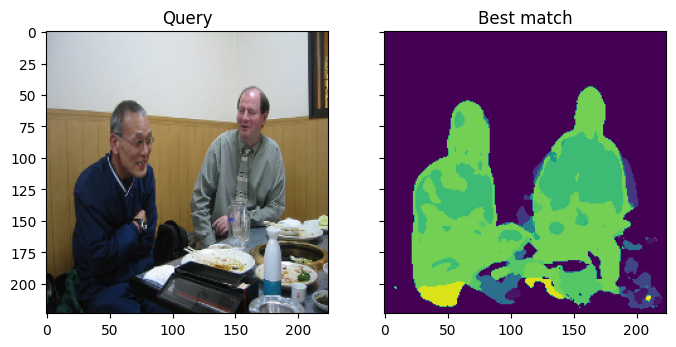

In [44]:
index = 11
img = X_test[index]
seg = np.argmax(predictions[index], axis=2)
print(np.unique(seg))
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(img)
axes[0].set_title("Query")
axes[1].imshow(seg)
axes[1].set_title("Best match")
plt.show()

In [ ]:
import cv2
gray = train_df["seg"][0]
color = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

def get_labelled_seg(img):
    """
     For segmentation task, read color image, transform it to 3-d one-hot encodeing class target image.
    :param img_path: the image path
    :return: target: (image_size,image_size,21)
    """
    image_size = 224
#     colored_img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    colored_img = color_seg(img, palette)
    plt.imshow(colored_img)
    
    resized_img = resize(colored_img, (image_size, image_size))
    img_224 = np.array(resized_img).astype('int32')    
    print(img_224.shape)
    
    idx = (img_224[:, :, 0] * 256 + img_224[:, :, 1]) * 256 + img_224[:, :, 2]
    print('id shape',idx.shape)
    img_mapped = np.array(colormap2class[idx], dtype='int64') # 2-d class map, class of every pixel
    
    return img_mapped

a = get_labelled_seg(train_df['seg'][0])
# plt.imshow(a)
# plt.imshow(train_df['seg'][0])
# a

#### Resize images for VGG16

In [7]:
from skimage.transform import resize
from skimage import io
from PIL import Image

def get_labelled_seg(images_seg):
    image_size = 224
    """
     For segmentation task, read color image, transform it to 3-d one-hot encodeing class target image.
    :param img_path: the image path
    :return: target: (image_size,image_size,21)
    """
    
    train_df_seg224 = np.array([resize(img, (image_size, image_size), Image.ANTIALIAS) for img in images_seg]).astype('int32')    
    train_df_seg_labelled = []
    for img in train_df_seg224:
        print(img.shape)
        idx = (img[:, :, 0] * 256 + img[:, :, 1]) * 256 + img[:, :, 2]
        train_df_seg_labelled.append(np.array(colormap2class[idx], dtype='int64')) # 2-d class map, class of every pixel
        
    return label_map

image_size = 224
train_df_img224 = np.array([resize(img, (image_size, image_size, 3)) for img in train_df["img"]]).astype('float32')
train_df_seg224 = np.array([resize(img, (image_size, image_size)) for img in train_df["seg"]]).astype('float32')

In [8]:
print(train_df_seg224[0].shape)

(224, 224)


In [6]:
# Comparing Resizing
lim = 1
for img in train_df_seg224[0:lim]:
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.imshow(img)
    
for img in train_df["seg"][0:lim]:
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.imshow(img)

NameError: name 'train_df_seg224' is not defined

### 3.2.2 Implementing transfering Learning

We will be implementing the following architecture, U-net follows from this U shape. In the first part the encoder is used to capture the context of the image. In the second part, in the decoder, we will use it to enable the precise localization. AS it can eb seen from the picture below there is no Dense layers above meaning we can take any picture size. Common structure for VGG16 is 224 img size  

![](https://raw.githubusercontent.com/danilotpnta/ComputerVission/main/img/U-net.png)
Img source: https://youtu.be/azM57JuQpQI

The above network uses skip connections, which means we will be skipping some layers in the NN. This skipping helps in traverse the information faster in the NN. It also helps in the problem of vanishing gradient descent. Thus, our Unet network will also account for this.

#### Lets create UNet, and the model

We will load the model imagenet weights and set the layers not to be trainable. The VGG16 represents only the encoder par thus, we need to define the decoder block.

In [28]:
from keras.utils.vis_utils import plot_model
# Based on tinyurl.com/2ohv3d8z

def upSampling(filter,input,concat,concat_encoder):    
    x = UpSampling2D(size=(2,2),interpolation='bilinear')(input) 
    x = Conv2D(filters=filter,kernel_size=(2,2),activation='relu',padding='same',kernel_initializer='he_normal')(x) 
    up_conv = BatchNormalization()(x)
    
    if concat:
        merged = tf.keras.layers.concatenate([concat_encoder,up_conv])
    else:
        merged = up_conv
    conv1 = BatchNormalization()(Conv2D(filters=filter,kernel_size=(3,3),activation='relu',padding='same',
                                        kernel_initializer='he_normal')(merged))
    conv2 = BatchNormalization()(Conv2D(filters=filter, kernel_size=(3, 3), activation='relu', padding='same',
                                        kernel_initializer='he_normal')(conv1))

    return conv2


def build_unet():
    # Create a VGG16 model, and remove the last layer. This will be replaced with the images classes we have. 
    image_size = 224
    vgg16 = VGG16(weights='imagenet',include_top = False,input_shape=(image_size,image_size,3))
    
    # Sets layers not trainable
    for layer in vgg16.layers:
        layer.trainable = False
        
    image_feature = vgg16.output

    n_classes = len(labels) + 1 # +1 background
    conv1 = Conv2D(filters=1024,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(image_feature)
    conv2 = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    decoder_input = Dropout(0.5)(conv2)
    
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv2").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    d1 = upSampling(filter=512,input=decoder_input,concat_encoder=b1,concat=True)
    d2 = upSampling(filter=256,input=d1, concat_encoder=s4,concat=True)
    d3 = upSampling(filter=128,input=d2, concat_encoder=s3,concat=True)
    d4 = upSampling(filter=64, input=d3, concat_encoder=s2,concat=True)
    d5 = upSampling(filter=64, input=d4, concat_encoder=s1,concat=False)

    outputs = Conv2D(filters=n_classes,kernel_size=(1,1),activation='softmax',padding='same',
                    kernel_initializer='he_normal',name='seg_output')(d5)

    model = Model(inputs=vgg16.input, outputs=outputs)
    return model


#Creating model object 
# model1 = build_unet()
# model1.summary()
# plot_model(model1, show_shapes=True, show_layer_names=True)

In [23]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.utils.vis_utils import plot_model
# Based on: tinyurl.com/2en5hr8k
 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x
 
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
 
def build_vgg16_unet():
 
    """ Pre-trained VGG16 Model """
    image_size = 224
    vgg16 = VGG16(weights='imagenet',include_top = False,input_shape= (image_size, image_size, 3))
    
    """ Sets layers not trainable """
    for layer in vgg16.layers:
        layer.trainable = False
 
    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)
 
    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)
 
    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
 
    """ Output """
    n_classes = len(labels) + 1 # +1 background
    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(d4)
 
    model = Model(vgg16.input, outputs, name="VGG16_U-Net")
    return model

# model = build_vgg16_unet()
# model.summary()
# plot_model(model, show_shapes=True, show_layer_names=True)

# Checks if all layers are set to not trainable 
# layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
# model_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])
# display(model_df)

#### Creating the Los function for optimizer

In [18]:
import tensorflow.keras.backend as K
# Based on: tinyurl.com/2zyh26mg

def dice_coef(y_true, y_pred):
    smooth = 1
    y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
    y_true = K.one_hot(tf.compat.v1.to_int32(K.flatten(y_true)), K.int_shape(y_pred)[-1])
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

#### Splitting the data

In [10]:
np.random.seed(12)
from sklearn.model_selection import train_test_split
Xtrain_seg, Xtest_seg, Ytrain_seg, Ytest_seg = train_test_split(train_df_img224,train_df_seg224,test_size=0.1, random_state=12)
print("X_training Images Size:", Xtrain_seg.shape)
print("Y_training Labels Size:", Ytrain_seg.shape)
print("X_test Images Size:", Xtest_seg.shape)
print("Y_test Labels Size:", Ytest_seg.shape)

X_training Images Size: (674, 224, 224, 3)
Y_training Labels Size: (674, 224, 224)
X_test Images Size: (75, 224, 224, 3)
Y_test Labels Size: (75, 224, 224)


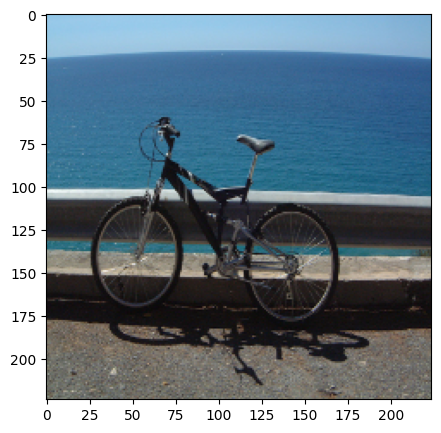

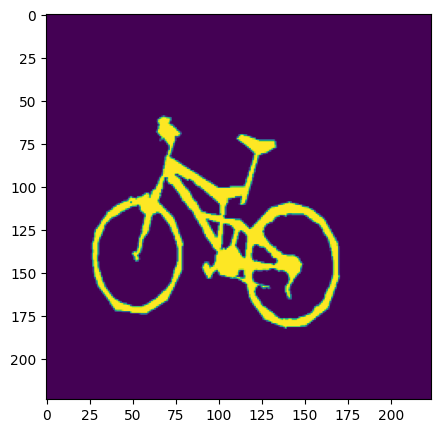

In [17]:
# Looking at split data
lim = 1
for img in Xtest_seg[0:lim]:
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.imshow(img)
    
for img in Ytest_seg[0:lim]:
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.imshow(img)

In [ ]:
lr = 0.0001
epochs = 25
batch_size = 24 

# model1 = build_unet()
# model1.compile(optimizer=keras.optimizers.Adam(learning_rate = lr),loss=dice_coef_loss, metrics=[dice_coef])
# model1_history = model1.fit(Xtrain_seg, Ytrain_seg, 
#                                          batch_size =  batch_size, 
#                                          epochs = epochs, 
#                                          validation_split=(0.1), 
#                                          shuffle=True)

model2 = build_vgg16_unet()
model2.compile(optimizer=keras.optimizers.Adam(learning_rate = lr, decay = lr/epochs ),loss=dice_coef_loss, metrics=[dice_coef])
model2_history = model2.fit(X_train, y_train, 
                          batch_size =  batch_size, 
                          epochs = epochs, 
                          validation_data=(X_test,y_test), 
                          shuffle=False)

In [ ]:
# Saving the model weights after training
from tensorflow.keras.models import load_model
model1.save('VGG16_model1.h5')



In [ ]:
""" Performance of the model 1 """
# for key in ['loss', 'val_loss',  'dice_coef', 'val_dice_coef' ]:
#     plt.plot(model1_history.history[key],label=key)
# plt.legend(['Loss', 'Loss: Val ',  'Loss: Dice_coef', 'Loss: Val Dice_coef' ])
# plt.title('Transfer Learning Model Results')
# plt.xlabel("Epochs")
# plt.ylabel("Error")
# plt.savefig('Loss_model_tf')
# plt.show()

![results](https://raw.githubusercontent.com/danilotpnta/ComputerVission/main/img/Loss_model_tf.png)

#### Predicting on the test set

In [ ]:
# Xtrain_seg, Xtest_seg, Ytrain_seg, Ytest_seg = train_test_split(train_df_img224,train_df_seg224,test_size=0.2, random_state=12)
y_pred_model1 = model1.predict(Xtest_seg)
# y_pred_model = model2.predict(Xtest_seg)

In [ ]:
# Model 
y_pred_max = np.argmax(y_pred_model1, axis=3)
print(y_pred_max.shape)

# for i in range(5):
#     plot_img_seg(Xtest_seg[i], Ytest_seg[i], y_pred_max[i])

### Loading model from link

In [3]:
!wget -O transfer_learning.h5 https://dl.dropboxusercontent.com/s/tm64mq9e0i44lhx/VGG16_model1.h5?dl=0

--2023-05-23 13:04:33--  https://dl.dropboxusercontent.com/s/tm64mq9e0i44lhx/VGG16_model1.h5?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 385860436 (368M) [text/plain]
Saving to: ‘transfer_learning.h5’

transfer_learning.h 100%[===================>] 367.98M  95.4MB/s    in 4.2s    

2023-05-23 13:04:39 (88.2 MB/s) - ‘transfer_learning.h5’ saved [385860436/385860436]



In [11]:
testing_tf_model1 = build_unet()
testing_tf_model1.load_weights("transfer_learning.h5")

y_pred_tf_model1 = testing_tf_model1.predict(Xtest_seg)
y_pred_tf_max = np.argmax(y_pred_tf_model1, axis=3)
print(y_pred_tf_max.shape)

3/3 [==============================] - 28s 3s/step
(75, 224, 224)


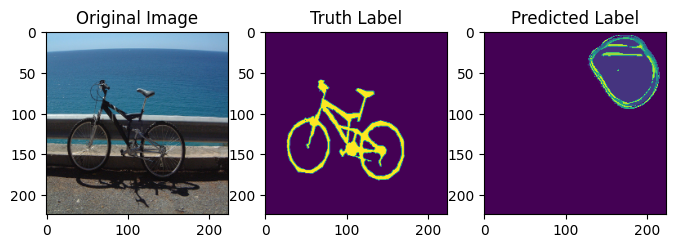

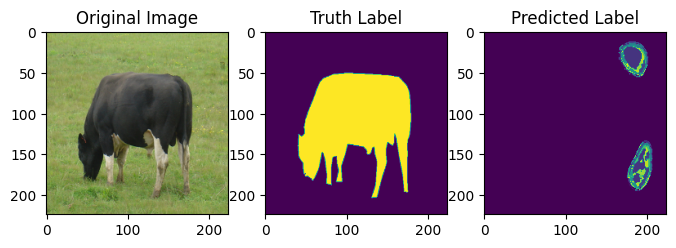

In [16]:
for i in range(2):
    plot_img_seg(Xtest_seg[i], Ytest_seg[i], y_pred_tf_max[i])

## Submit to competition
You don't need to edit this section. Just use it at the right position in the notebook. See the definition of this function in Sect. 1.3 for more details.

In [ ]:
generate_submission(test_df)

# 4. Adversarial attack
For this part, your goal is to fool your classification and/or segmentation CNN, using an *adversarial attack*. More specifically, the goal is build a CNN to perturb test images in a way that (i) they look unperturbed to humans; but (ii) the CNN classifies/segments these images in line with the perturbations.

# 5. Discussion
Finally, take some time to reflect on what you have learned during this assignment. Reflect and produce an overall discussion with links to the lectures and "real world" computer vision.